# Fitting Mazzoni et al. (2015) data for inter- and extrapolation

Contributors: [Olivia Klemmer](https://www.linkedin.com/in/oliviaklemmer/), [Aarav Shah](https://www.linkedin.com/in/aarav-shah-cs/), and [Kyle Johnsen](https://kjohnsen.org)

## Original Graph with Extracted Data

(<Figure size 300x300 with 2 Axes>,
 <Axes: title={'center': 'LFP amplitude (μV)'}, xlabel='Electrode lateral distance (μm)', ylabel='Electrode depth (μm)'>)

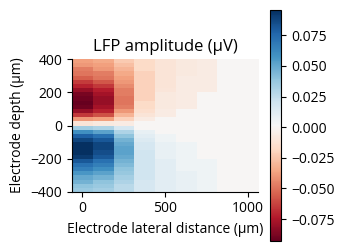

In [19]:
import wslfp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv("mazzoni15-amp.csv", index_col=0).iloc[::-1]
wslfp.amplitude.plot_amp(df.values, extent=[-62.5, 1062.5, -400, 400])

## Beta Distribution Extrapolation

/tmp/ipykernel_4061/2767919588.py:22: OptimizeWarning: Covariance of the parameters could not be estimated
  result = curve_fit(


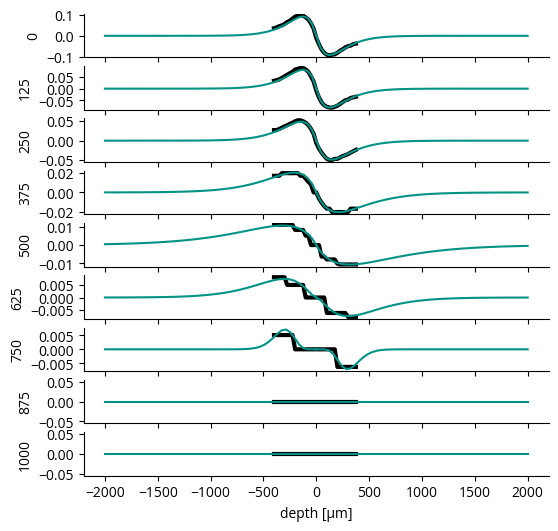

In [34]:
from scipy.interpolate import LinearNDInterpolator
from scipy.stats import beta
from scipy.optimize import curve_fit

pop_radius_um = 250  # um
f = df.values
r = df.columns.astype(float).to_numpy() * pop_radius_um
d = df.index.astype(float).to_numpy()

a = np.zeros_like(r)
b = np.zeros_like(r)
loc = np.zeros_like(r)
scale = np.zeros_like(r)
dmax = np.zeros_like(r)


def f_beta(r, a, b, scale, dmax):
    return beta.pdf(r / dmax, a, b, loc=0, scale=scale)


def opt(amp_values, p0):
    result = curve_fit(
        f_beta, d[16:], -amp_values[16:], method="lm", maxfev=100000, p0=p0
    )
    a, b, scale, dmax = result[0]
    return a, b, scale, dmax


p0 = [2.92851034e00, 2.23967397e07, 6.45591424e07, 2.91873521e01]
d_eval = np.linspace(0, 2000)
rdf_samples = np.empty((0, 3))
fig, axs = plt.subplots(len(r), 1, figsize=(6, 6), sharex=True)
for i in range(len(r)):
    axs[i].plot(d, f[:, i], c="k", lw=3)

    a[i], b[i], scale[i], dmax[i] = opt(f[:, i], p0)
    f_i = -beta.pdf(d_eval / dmax[i], a[i], b[i], scale=scale[i])
    axs[i].plot(d_eval, f_i, c="xkcd:teal")
    axs[i].plot(-d_eval, -f_i, c="xkcd:teal")
    axs[i].set(ylabel=f"{r[i]:.0f}")

    axs[i].set(xlabel="depth [μm]")
    p0 = [a[i], b[i], scale[i], dmax[i]]

    rdf_i = np.column_stack(np.broadcast_arrays(r[i], d_eval, f_i))
    rdf_samples = np.concatenate([rdf_samples, rdf_i])

np.save("../wslfp/mazzoni15-rdf.npy", rdf_samples)
np.savez_compressed(
    "../wslfp/mazzoni15-beta-params.npz", a=a, b=b, scale=scale, dmax=dmax, rslices=r
)